# Intial test to see time series classification

## Load libs

In [1]:
import os
import json
import glob
import pandas as pd
import numpy as np
from datetime import datetime

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Load data and labels

In [2]:
# Paths
json_path = './data_labelled/project-3-at-2025-06-30-17-49-c0b2a0a1.json'      # exported JSON from Label Studio
csv_folder = './data_preprocess'                # Folder with original CSVs

# Load label JSON
with open(json_path, 'r') as f:
    label_data = json.load(f)

def load_csv_for_task(task):
    # Extract filename after last slash
    full_filename = os.path.basename(task['csv'])  # e.g. "454c4a18-Mov-FluA-BEG.csv"
    
    # Find index of 'Mov-' in filename, and strip prefix before it
    mov_idx = full_filename.find('Mov-')
    if mov_idx >= 0:
        filename = full_filename[mov_idx:]  # e.g. "Mov-FluA-BEG.csv"
    else:
        filename = full_filename  # fallback, just use full filename

    csv_path = os.path.join(csv_folder, filename)
    df = pd.read_csv(csv_path)
    df['filename'] = filename
    
    return df

def filter_tasks_by_virus(tasks, virus_keyword):
    filtered = []
    for task in tasks:
        full_filename = os.path.basename(task['csv']).lower()
        mov_idx = full_filename.find('Mov-')
        if mov_idx >= 0:
            filename = full_filename[mov_idx:]  # strip prefix
        else:
            filename = full_filename
        if virus_keyword.lower() in filename:
            filtered.append(task)
    return filtered

def assign_labels_to_df(df, labels):
    # Create a new column 'label' initialized empty
    df['label'] = None

    for lab in labels:
        start = pd.to_datetime(lab['start'])
        end = pd.to_datetime(lab['end'])
        label_name = lab['timeserieslabels'][0]  # e.g. 'start', 'peak', etc.
        df['time'] = pd.to_datetime(df['time'])
        mask = (df['time'] >= start) & (df['time'] < end)
        df.loc[mask, 'label'] = label_name

    return df


explore the label data

In [3]:
label_data[1]

{'csv': '/data/upload/3/03ae4b96-Mov-FluA-BET.csv',
 'id': 2,
 'label': [{'start': '2022-02-28',
   'end': '2022-03-07',
   'instant': False,
   'timeserieslabels': ['start']},
  {'start': '2022-03-07',
   'end': '2022-04-18',
   'instant': False,
   'timeserieslabels': ['on going']},
  {'start': '2022-04-18',
   'end': '2022-05-23',
   'instant': False,
   'timeserieslabels': ['end']},
  {'start': '2021-12-06',
   'end': '2022-01-03',
   'instant': False,
   'timeserieslabels': ['on going']},
  {'start': '2021-10-18',
   'end': '2021-12-06',
   'instant': False,
   'timeserieslabels': ['none']},
  {'start': '2022-01-03',
   'end': '2022-02-28',
   'instant': False,
   'timeserieslabels': ['none']},
  {'start': '2022-05-23',
   'end': '2022-12-12',
   'instant': False,
   'timeserieslabels': ['none']},
  {'start': '2022-12-12',
   'end': '2022-12-12',
   'instant': True,
   'timeserieslabels': ['start']},
  {'start': '2022-12-12',
   'end': '2023-01-09',
   'instant': False,
   'timese

## Filter for virus

In [4]:
virus_name = "FluA"  
tasks = filter_tasks_by_virus(label_data, virus_name)

dfs_flua = []
for task in tasks:
    df = load_csv_for_task(task)
    df = assign_labels_to_df(df, task.get('label', []))
    df['virus'] = virus_name.upper()
    dfs_flua.append(df)

all_data = pd.concat(dfs_flua, ignore_index=True)
print(all_data.head())

all_data['label'] = all_data['label'].fillna('none')

        time  rna_copies label          filename virus
0 2021-10-18         0.0  none  Mov-FluA-BEG.csv  FLUA
1 2021-10-25         0.0  none  Mov-FluA-BEG.csv  FLUA
2 2021-11-01         0.0  none  Mov-FluA-BEG.csv  FLUA
3 2021-11-08         0.0  none  Mov-FluA-BEG.csv  FLUA
4 2021-11-15         0.0  none  Mov-FluA-BEG.csv  FLUA


In [5]:
all_data['label'].unique()

array(['none', 'on going', 'start', 'end'], dtype=object)

In [6]:
all_data['filename'].unique()

array(['Mov-FluA-BEG.csv', 'Mov-FluA-BET.csv', 'Mov-FluA-BLE.csv',
       'Mov-FluA-ECH.csv', 'Mov-FluA-MER.csv', 'Mov-FluA-Nat.csv',
       'Mov-FluA-PET.csv', 'Mov-FluA-SCH.csv', 'Mov-FluA-UEB.csv'],
      dtype=object)

## Save the labeled data

In [7]:
for filename in all_data['filename'].unique():
    df_local = all_data[all_data['filename'] == filename]
    df_local.to_csv(f'./data_labelled/{filename}', index=False)
    print(f'Saved {filename} with {len(df_local)} rows')

Saved Mov-FluA-BEG.csv with 192 rows
Saved Mov-FluA-BET.csv with 192 rows
Saved Mov-FluA-BLE.csv with 36 rows
Saved Mov-FluA-ECH.csv with 36 rows
Saved Mov-FluA-MER.csv with 36 rows
Saved Mov-FluA-Nat.csv with 192 rows
Saved Mov-FluA-PET.csv with 191 rows
Saved Mov-FluA-SCH.csv with 192 rows
Saved Mov-FluA-UEB.csv with 37 rows


label imbalance

C:\Users\adhav\AppData\Local\Temp\ipykernel_4884\292170352.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=label_counts, x='label', y='count', palette='muted')


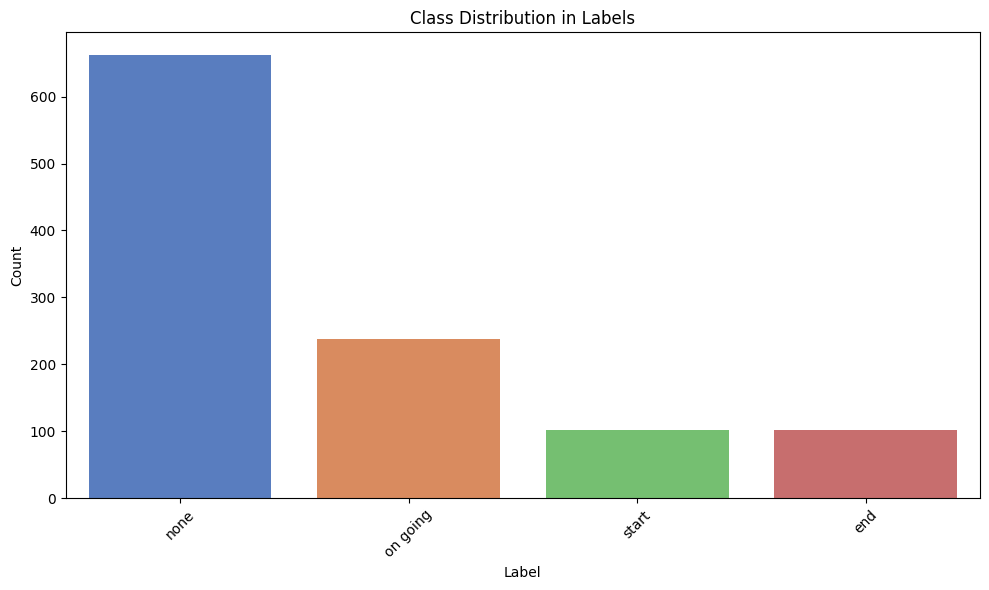

In [8]:
# Count occurrences of each label
label_counts = 0
label_counts = all_data['label'].value_counts().reset_index()
label_counts.columns = ['label', 'count']

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=label_counts, x='label', y='count', palette='muted')
plt.title('Class Distribution in Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Prepare the train-test split for the model

In [9]:
# Drop rows with no label (optional)
data_labeled = all_data.dropna(subset=['label']).copy()

# Encode label column to numeric for classification
label_mapping = {label: idx for idx, label in enumerate(data_labeled['label'].unique())}
data_labeled['label_encoded'] = data_labeled['label'].map(label_mapping)

print("Label mapping:", label_mapping)

# Use rna_copies as feature - expand with more features if available
X = data_labeled[['rna_copies']]
y = data_labeled['label_encoded']

# Split 70% train, 20% test, 10% validation
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42, stratify=y_trainval)  
# 0.125 x 0.7 = ~0.0875 (close to 10%)
print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")


Label mapping: {'none': 0, 'on going': 1, 'start': 2, 'end': 3}
Train size: 675, Val size: 97, Test size: 332


## XgBoost model and params

In [10]:
# Define XGBoost params

# Best params: {'colsample_bytree': 0.6, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
# Best accuracy: 0.7881481481481482

params = {
    'objective': 'multi:softprob',  # multi-class classification with probabilities
    'num_class': len(label_mapping),
    'eval_metric': 'mlogloss',
    'max_depth': 3,
    'eta': 0.01,
    'subsample': 1,
    'colsample_bytree':  0.6,
    'seed': 42,
    'verbosity': 1,
    'min_child_weight': 1,
    'lambda': 5,
    'alpha': 1
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

evals = [(dtrain, 'train'), (dval, 'val')]
evals_result = {}

bst = xgb.train(params, 
                dtrain, 
                num_boost_round=1000, 
                evals=evals, 
                evals_result=evals_result,
                early_stopping_rounds=250)


[0]	train-mlogloss:1.37443	val-mlogloss:1.37431
[1]	train-mlogloss:1.36280	val-mlogloss:1.36257
[2]	train-mlogloss:1.35139	val-mlogloss:1.35105
[3]	train-mlogloss:1.34018	val-mlogloss:1.33974
[4]	train-mlogloss:1.32919	val-mlogloss:1.32865
[5]	train-mlogloss:1.31839	val-mlogloss:1.31776
[6]	train-mlogloss:1.30778	val-mlogloss:1.30714
[7]	train-mlogloss:1.29731	val-mlogloss:1.29665
[8]	train-mlogloss:1.28707	val-mlogloss:1.28640
[9]	train-mlogloss:1.27702	val-mlogloss:1.27628
[10]	train-mlogloss:1.26707	val-mlogloss:1.26639
[11]	train-mlogloss:1.25737	val-mlogloss:1.25663
[12]	train-mlogloss:1.24775	val-mlogloss:1.24708
[13]	train-mlogloss:1.23838	val-mlogloss:1.23765
[14]	train-mlogloss:1.22915	val-mlogloss:1.22838
[15]	train-mlogloss:1.22002	val-mlogloss:1.21932
[16]	train-mlogloss:1.21110	val-mlogloss:1.21036
[17]	train-mlogloss:1.20231	val-mlogloss:1.20159
[18]	train-mlogloss:1.19363	val-mlogloss:1.19294
[19]	train-mlogloss:1.18513	val-mlogloss:1.18446
[20]	train-mlogloss:1.17672	va

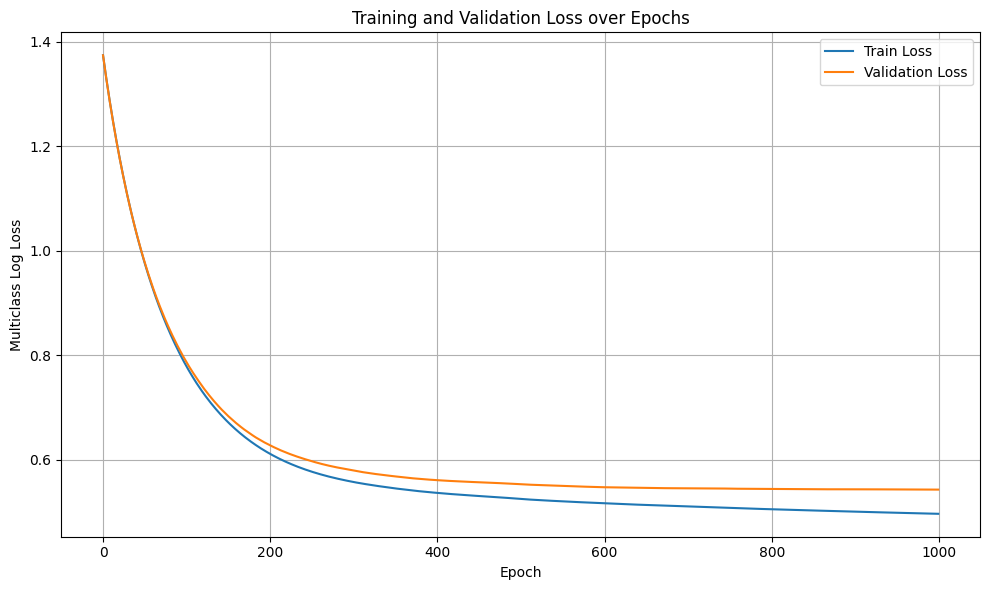

In [11]:
# Extract loss values
train_loss = evals_result['train']['mlogloss']
val_loss = evals_result['val']['mlogloss']

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Multiclass Log Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Plot metrics

              precision    recall  f1-score   support

        none       0.87      0.97      0.92       199
    on going       0.79      0.70      0.75        71
       start       0.55      0.39      0.45        31
         end       0.38      0.32      0.35        31

    accuracy                           0.80       332
   macro avg       0.65      0.60      0.62       332
weighted avg       0.78      0.80      0.79       332



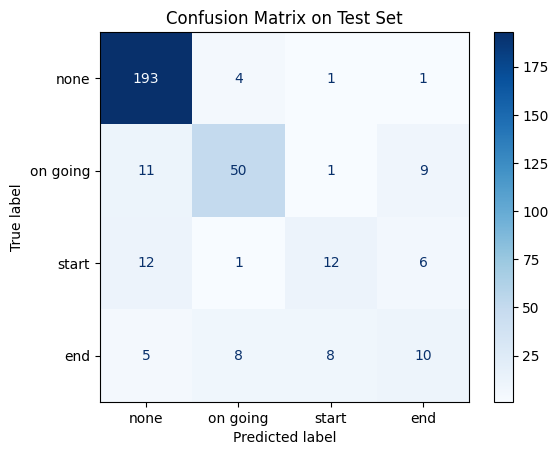

In [12]:
# Predict test labels
y_pred_prob = bst.predict(dtest)
y_pred = np.argmax(y_pred_prob, axis=1)

print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()


## grid search

In [13]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'eta': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(label_mapping),
    eval_metric='mlogloss',
    seed=42,
    use_label_encoder=False
)

grid_search = GridSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)

c:\Users\adhav\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adhav\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\adhav\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Best params: {'colsample_bytree': 0.6, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0}
Best accuracy: 0.7881481481481482
